# ETL Pipeline for Movie Ratings Database

In [1]:
import json
import pathlib
import re

import numpy as np
import pandas as pd

## Extract Stage

In [2]:
file_dir = './Data'
file_path = pathlib.Path(file_dir, 'wikipedia-movies.json')

with open(file_path, mode='r') as file:
    wiki_movies_raw = json.load(file)

In [3]:
print('number of records:', len(wiki_movies_raw))

wiki_movies_raw[-5:]

number of records: 7311


[{'url': 'https://en.wikipedia.org/wiki/Holmes_%26_Watson',
  'year': 2018,
  'imdb_link': 'https://www.imdb.com/title/tt1255919/',
  'title': 'Holmes & Watson',
  'Directed by': 'Etan Cohen',
  'Produced by': ['Will Ferrell',
   'Adam McKay',
   'Jimmy Miller',
   'Clayton Townsend'],
  'Screenplay by': 'Etan Cohen',
  'Based on': ['Sherlock Holmes',
   'and',
   'Dr. Watson',
   'by',
   'Sir Arthur Conan Doyle'],
  'Starring': ['Will Ferrell',
   'John C. Reilly',
   'Rebecca Hall',
   'Rob Brydon',
   'Steve Coogan',
   'Ralph Fiennes'],
  'Music by': 'Mark Mothersbaugh',
  'Cinematography': 'Oliver Wood',
  'Edited by': 'Dean Zimmerman',
  'Productioncompanies ': ['Columbia Pictures',
   'Gary Sanchez Productions',
   'Mosaic Media Group',
   'Mimran Schur Pictures'],
  'Distributed by': 'Sony Pictures Releasing',
  'Release date': ['December 25, 2018',
   '(',
   '2018-12-25',
   ')',
   '(United States)'],
  'Running time': '90 minutes',
  'Country': 'United States',
  'Language

In [4]:
kaggle_metadata_df = pd.read_csv(pathlib.Path(file_dir, 'movies_metadata.csv'), low_memory=False)
kaggle_ratings_df = pd.read_csv(pathlib.Path(file_dir, 'ratings.csv'))

In [5]:
kaggle_metadata_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [6]:
kaggle_ratings_df.sample(5)

,userId,movieId,rating,timestamp
1015347,10332,2985,3.5,1477358686
4925232,50686,8640,2.0,1375467172
25506610,265503,2542,4.0,1202394517
455575,4703,4308,5.0,1462066160
17353450,180117,3996,4.0,1194463149


<hr/>

## Transformation Stage: Wikipedia Data

### Raw JSON to DataFrame

In [7]:
wiki_movies_raw_df = pd.DataFrame(wiki_movies_raw)
wiki_movies_raw_df.head()

,url,year,imdb_link,title,Directed by,Produced by,Screenplay by,Story by,Based on,Starring,...,Predecessor,Founders,Area served,Products,Services,Russian,Hebrew,Revenue,Operating income,Polish
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990.0,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,Renny Harlin,"[Steve Perry, Joel Silver]","[David Arnott, James Cappe, Daniel Waters]","[David Arnott, James Cappe]","[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990.0,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet",James Foley,"[Ric Kidney, Robert Redlin]","[James Foley, Robert Redlin]",NaN,"[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://en.wikipedia.org/wiki/Air_America_(film),1990.0,https://www.imdb.com/title/tt0099005/,Air America,Roger Spottiswoode,Daniel Melnick,"[John Eskow, Richard Rush]",NaN,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990.0,https://www.imdb.com/title/tt0099012/,Alice,Woody Allen,Robert Greenhut,NaN,NaN,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990.0,https://www.imdb.com/title/tt0099018/,Almost an Angel,John Cornell,John Cornell,NaN,NaN,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
wiki_movies_raw_df.columns.tolist()

['url',
 'year',
 'imdb_link',
 'title',
 'Directed by',
 'Produced by',
 'Screenplay by',
 'Story by',
 'Based on',
 'Starring',
 'Narrated by',
 'Music by',
 'Cinematography',
 'Edited by',
 'Productioncompany ',
 'Distributed by',
 'Release date',
 'Running time',
 'Country',
 'Language',
 'Budget',
 'Box office',
 'Written by',
 'Genre',
 'Theme music composer',
 'Country of origin',
 'Original language(s)',
 'Producer(s)',
 'Editor(s)',
 'Production company(s)',
 'Original network',
 'Original release',
 'Productioncompanies ',
 'Executive producer(s)',
 'Production location(s)',
 'Distributor',
 'Picture format',
 'Audio format',
 'Voices of',
 'Followed by',
 'Composer(s)',
 'Created by',
 'Also known as',
 'Opening theme',
 'No. of episodes',
 'Preceded by',
 'Author',
 'Publisher',
 'Publication date',
 'Media type',
 'Pages',
 'ISBN',
 'OCLC',
 'LC Class',
 'Cover artist',
 'Series',
 'Set in',
 'Adaptation by',
 'Suggested by',
 'Biographical data',
 'Born',
 'Died',
 'Resti

### Filter out Non-Movies

In [9]:
# Filter out movies without 'Director'/'Directed by', and 'imdb_link' as keys
wiki_movies = [movie for movie in wiki_movies_raw 
               if ('Director' in movie or 'Directed by' in movie)
               and 'imdb_link' in movie
               and 'No. of episodes' not in movie]
len(wiki_movies)

7076

### Consolidate Columns

In [10]:
def clean_movie(movie):
    """Consolidates columns of data that represent the same information
    """
    
    movie = dict(movie)  # create a nondestructive copy
    
    # Names of columns that hold alternate titles
    alt_title_keys = ['Also known as','Arabic','Cantonese','Chinese','French',
                    'Hangul','Hebrew','Hepburn','Japanese','Literally',
                    'Mandarin','McCune–Reischauer','Original title','Polish',
                    'Revised Romanization','Romanized','Russian',
                    'Simplified','Traditional','Yiddish']
    # A dict to hold values for the new alternate titles column: 'alt_titles'
    alt_titles = {}
    
    # Combine alternate titles into one list
    for key in alt_title_keys:
        # If the key is found, we remove it from the movie object and add it to
        # the dict so that we can add it to a new column 'alt_titles' below
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
            
    # If alt_titles is non-empty, assign the values to the new 'alt_titles' 
    # column
    if alt_titles:
        movie['alt_titles'] = alt_titles
    
    # A function to consolidate columns that represent the same information
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
    
    change_column_name('Adaptation by', 'Writer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release Date')
    change_column_name('Release Date', 'Release date')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Theme music composer', 'Composer(s)')
    change_column_name('Written by', 'Writer(s)')
    
    return movie

In [11]:
clean_movies = [clean_movie(movie) for movie in wiki_movies]

wiki_movies_df = pd.DataFrame(clean_movies)
sorted(wiki_movies_df.columns.tolist())

['Animation by',
 'Audio format',
 'Based on',
 'Box office',
 'Budget',
 'Cinematography',
 'Color process',
 'Composer(s)',
 'Country',
 'Created by',
 'Director',
 'Distributor',
 'Editor(s)',
 'Executive producer(s)',
 'Followed by',
 'Genre',
 'Label',
 'Language',
 'Narrated by',
 'Original language(s)',
 'Original network',
 'Picture format',
 'Preceded by',
 'Producer(s)',
 'Production company(s)',
 'Production location(s)',
 'Recorded',
 'Release date',
 'Running time',
 'Starring',
 'Suggested by',
 'Venue',
 'Voices of',
 'Writer(s)',
 'alt_titles',
 'imdb_link',
 'title',
 'url',
 'year']

### Remove Duplicate Rows

In [12]:
# Extract the imdb_id using a regular expression
wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
print(len(wiki_movies_df))
# Use the imdb_id to drop duplicate records
wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
print(len(wiki_movies_df))

7076
7033


### Remove Mostly Null Columns

In [13]:
wiki_movies_df.isnull().sum()

url                          0
year                         0
imdb_link                    0
title                        1
Based on                  4852
Starring                   184
Narrated by               6752
Cinematography             691
Release date                32
Running time               139
Country                    236
Language                   244
Budget                    2295
Box office                1548
Director                     0
Distributor                357
Editor(s)                  548
Composer(s)                518
Producer(s)                202
Production company(s)     1678
Writer(s)                  199
Genre                     6923
Original language(s)      6875
Original network          6908
Executive producer(s)     6936
Production location(s)    6986
Picture format            6969
Audio format              6972
Voices of                 7031
Followed by               7024
Created by                7023
Preceded by               7023
Suggeste

In [14]:
num_records = len(wiki_movies_df)

# Keep columns with less than 90% null values
wiki_columns_to_keep = [column for column in wiki_movies_df.columns
                        if (wiki_movies_df[column].isnull().sum() < num_records * 0.9)]
wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]
wiki_movies_df.head()

,url,year,imdb_link,title,Based on,Starring,Cinematography,Release date,Running time,Country,...,Budget,Box office,Director,Distributor,Editor(s),Composer(s),Producer(s),Production company(s),Writer(s),imdb_id
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,"[July 11, 1990, (, 1990-07-11, )]",102 minutes,United States,...,$20 million,$21.4 million,Renny Harlin,20th Century Fox,Michael Tronick,"[Cliff Eidelman, Yello]","[Steve Perry, Joel Silver]",Silver Pictures,"[David Arnott, James Cappe]",tt0098987
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,"[May 17, 1990, (, 1990-05-17, ), (Cannes Film ...",114 minutes,United States,...,$6 million,$2.7 million,James Foley,Avenue Pictures,Howard E. Smith,Maurice Jarre,"[Ric Kidney, Robert Redlin]",Avenue Pictures,"[James Foley, Robert Redlin]",tt0098994
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,"[August 10, 1990, (, 1990-08-10, )]",113 minutes,United States,...,$35 million,"$57,718,089",Roger Spottiswoode,TriStar Pictures,"[John Bloom, Lois Freeman-Fox]",Charles Gross,Daniel Melnick,"[Carolco Pictures, IndieProd Company]","[John Eskow, Richard Rush]",tt0099005
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,"[December 25, 1990, (, 1990-12-25, )]",106 minutes,United States,...,$12 million,"$7,331,647",Woody Allen,Orion Pictures,Susan E. Morse,NaN,Robert Greenhut,NaN,Woody Allen,tt0099012
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,"December 19, 1990",95 minutes,US,...,$25 million,"$6,939,946 (USA)",John Cornell,Paramount Pictures,David Stiven,Maurice Jarre,John Cornell,NaN,Paul Hogan,tt0099018


In [15]:
wiki_movies_df.isnull().sum()

url                         0
year                        0
imdb_link                   0
title                       1
Based on                 4852
Starring                  184
Cinematography            691
Release date               32
Running time              139
Country                   236
Language                  244
Budget                   2295
Box office               1548
Director                    0
Distributor               357
Editor(s)                 548
Composer(s)               518
Producer(s)               202
Production company(s)    1678
Writer(s)                 199
imdb_id                     0
dtype: int64

### Converting Columns to Correct Data Types

#### Forms and Functions for Parsing

##### Forms to Match

In [16]:
# Form to match $#.## million/billion
form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'
# Form to match $###,###,###
form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s*[mb]illi?on)'

##### Function for Matching Forms

In [17]:
def matches_form(column_data, forms):
    """
    Takes in a Series (column_data) and a list of regular expressions (forms)
    and returns a list of Series containing Boolean elements based on matches to
    each respective regex
    """
    
    matches = []
    
    for form in forms:
        # Apply contains() element-wise via str
        match = column_data.str.contains(form, flags=re.IGNORECASE, na=False)
        matches.append(match)
    
    return matches

##### Function for Parsing Currency Data

In [18]:
def parse_dollars(s):
    """Parse strings representing currency into numerical values
    """
    
    # if s is not a string, return NaN
    if type(s) != str:
        return np.nan
    
    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):
        # remove dollar sign and " million"
        s = re.sub(r'\$|\s|[a-zA-Z]', '', s)
        # convert to float and multiply by a million
        value = float(s) * 10**6
        # return value
        return value
    
    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):
        # remove dollar sign and " billion"
        s = re.sub(r'\$|\s|[a-zA-Z]', '', s)
        # convert to float and multiply by a billion
        value = float(s) * 10**9
        # return value
        return value
    
    # if input is of the form $###,###,###
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):
        # remove dollar sign and commas
        s = re.sub(r'\$|\s|,', '', s)
        # convert to float
        value = float(s)
        # return value
        return value
    
    # otherwise, return NaN
    else:
        return np.nan

<hr/>

#### Parse Box Office Column

##### Preprocessing the Column

In [19]:
# Drop any NaN or Null values
box_office = wiki_movies_df['Box office'].dropna()

# Convert any lists to strings
box_office = box_office.map(lambda x: ' '.join(x) if type(x) == list else x)

# Remove any values between a dollar sign and a hypen (eliminate ranges)
box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

##### What Remains After Matching

In [20]:
matches = matches_form(box_office, [form_one, form_two])
box_office[~matches[0] & ~matches[1]]

600                      $5000 (US)
1070                     35,254,617
1480                     £3 million
1865                   ¥1.1 billion
2032                            N/A
2091                           $309
2665    926,423 admissions (France)
3631                            TBA
3879       CN¥3.650 million (China)
4116                     £7,385,434
4306                            $30
4561        $45.2k (only in Turkey)
5447                          £2.56
5784                       413 733$
6013                        Unknown
6369                          $111k
6370                           $588
6593                 less than $372
6843                        8 crore
Name: Box office, dtype: object

##### Replace Old Column with New Cleaned Column

In [21]:
# Create a new "cleaned" box office column
wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})',
                                                      flags=re.IGNORECASE)[0].apply(parse_dollars)

# Drop the old "uncleaned" box office column
wiki_movies_df.drop('Box office', axis=1, inplace=True)

wiki_movies_df.head()

,url,year,imdb_link,title,Based on,Starring,Cinematography,Release date,Running time,Country,...,Budget,Director,Distributor,Editor(s),Composer(s),Producer(s),Production company(s),Writer(s),imdb_id,box_office
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,"[July 11, 1990, (, 1990-07-11, )]",102 minutes,United States,...,$20 million,Renny Harlin,20th Century Fox,Michael Tronick,"[Cliff Eidelman, Yello]","[Steve Perry, Joel Silver]",Silver Pictures,"[David Arnott, James Cappe]",tt0098987,21400000.0
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,"[May 17, 1990, (, 1990-05-17, ), (Cannes Film ...",114 minutes,United States,...,$6 million,James Foley,Avenue Pictures,Howard E. Smith,Maurice Jarre,"[Ric Kidney, Robert Redlin]",Avenue Pictures,"[James Foley, Robert Redlin]",tt0098994,2700000.0
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,"[August 10, 1990, (, 1990-08-10, )]",113 minutes,United States,...,$35 million,Roger Spottiswoode,TriStar Pictures,"[John Bloom, Lois Freeman-Fox]",Charles Gross,Daniel Melnick,"[Carolco Pictures, IndieProd Company]","[John Eskow, Richard Rush]",tt0099005,57718089.0
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,"[December 25, 1990, (, 1990-12-25, )]",106 minutes,United States,...,$12 million,Woody Allen,Orion Pictures,Susan E. Morse,NaN,Robert Greenhut,NaN,Woody Allen,tt0099012,7331647.0
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,"December 19, 1990",95 minutes,US,...,$25 million,John Cornell,Paramount Pictures,David Stiven,Maurice Jarre,John Cornell,NaN,Paul Hogan,tt0099018,6939946.0


<hr/>

#### Parse Budget Column

##### Preprocessing the Column

In [22]:
# Drop any NaN or Null values
budget = wiki_movies_df['Budget'].dropna()

# Convert any lists to strings
budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)

# Remove any values between a dollar sign and a hypen (eliminate ranges)
budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

# Remove citations [#] that are in the middle of the number
budget = budget.str.replace(r'\[\d+\]\s*', '', regex=True)

##### What Remains After Matching

In [23]:
matches = matches_form(budget, [form_one, form_two])
type(budget[~matches[0] & ~matches[1]])

pandas.core.series.Series

##### Replace Old Column with New Cleaned Column

In [24]:
# Create a new "cleaned" box office column
wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})',
                                              flags=re.IGNORECASE)[0].apply(parse_dollars)

# Drop the old "uncleaned" box office column
wiki_movies_df.drop('Budget', axis=1, inplace=True)

wiki_movies_df.head()

,url,year,imdb_link,title,Based on,Starring,Cinematography,Release date,Running time,Country,...,Director,Distributor,Editor(s),Composer(s),Producer(s),Production company(s),Writer(s),imdb_id,box_office,budget
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,"[July 11, 1990, (, 1990-07-11, )]",102 minutes,United States,...,Renny Harlin,20th Century Fox,Michael Tronick,"[Cliff Eidelman, Yello]","[Steve Perry, Joel Silver]",Silver Pictures,"[David Arnott, James Cappe]",tt0098987,21400000.0,20000000.0
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,"[May 17, 1990, (, 1990-05-17, ), (Cannes Film ...",114 minutes,United States,...,James Foley,Avenue Pictures,Howard E. Smith,Maurice Jarre,"[Ric Kidney, Robert Redlin]",Avenue Pictures,"[James Foley, Robert Redlin]",tt0098994,2700000.0,6000000.0
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,"[August 10, 1990, (, 1990-08-10, )]",113 minutes,United States,...,Roger Spottiswoode,TriStar Pictures,"[John Bloom, Lois Freeman-Fox]",Charles Gross,Daniel Melnick,"[Carolco Pictures, IndieProd Company]","[John Eskow, Richard Rush]",tt0099005,57718089.0,35000000.0
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,"[December 25, 1990, (, 1990-12-25, )]",106 minutes,United States,...,Woody Allen,Orion Pictures,Susan E. Morse,NaN,Robert Greenhut,NaN,Woody Allen,tt0099012,7331647.0,12000000.0
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,"December 19, 1990",95 minutes,US,...,John Cornell,Paramount Pictures,David Stiven,Maurice Jarre,John Cornell,NaN,Paul Hogan,tt0099018,6939946.0,25000000.0


<hr/>

#### Parse Release Date

##### Forms to Match

In [25]:
date_form_one = (r'(?:January|February|March|April|May|June|July|August|September|October|November|December)'
                 r'\s[123]?\d,\s\d{4}')
date_form_two = r'\d{4}.[01]\d.[0123]\d'
date_form_three = (r'(?:January|February|March|April|May|June|July|August|September|October|November|December)'
                   r'\s\d{4}')
date_form_four = r'\d{4}'

##### Preprocessing the Column

In [26]:
# Drop any NaN or Null values
release_date = wiki_movies_df['Release date'].dropna()

# Convert any lists to strings
release_date = release_date.map(lambda x: ' '.join(x) if type(x) == list else x)

##### What Remains After Matching

In [27]:
matches = matches_form(release_date, [date_form_one,
                                      date_form_two,
                                      date_form_three,
                                      date_form_four])

release_date[(~matches[0] & ~matches[1]) & (~matches[2] & ~matches[3])]

Series([], Name: Release date, dtype: object)

##### Replace Old Column with New Cleaned Column

In [28]:
# Matches is a dataframe with one column named 0
matches = release_date.str.extract(f'({date_form_one}|{date_form_two}'
                                   f'|{date_form_three}|{date_form_four})',
                                   flags=re.IGNORECASE)

# Create a new "cleaned" box office column
wiki_movies_df['release_date'] = pd.to_datetime(matches[0], infer_datetime_format=True)

# Drop the old "uncleaned" box office column
wiki_movies_df.drop('Release date', axis=1, inplace=True)

wiki_movies_df.head()

,url,year,imdb_link,title,Based on,Starring,Cinematography,Running time,Country,Language,...,Distributor,Editor(s),Composer(s),Producer(s),Production company(s),Writer(s),imdb_id,box_office,budget,release_date
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,102 minutes,United States,English,...,20th Century Fox,Michael Tronick,"[Cliff Eidelman, Yello]","[Steve Perry, Joel Silver]",Silver Pictures,"[David Arnott, James Cappe]",tt0098987,21400000.0,20000000.0,1990-07-11
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,114 minutes,United States,English,...,Avenue Pictures,Howard E. Smith,Maurice Jarre,"[Ric Kidney, Robert Redlin]",Avenue Pictures,"[James Foley, Robert Redlin]",tt0098994,2700000.0,6000000.0,1990-05-17
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,113 minutes,United States,"[English, Lao]",...,TriStar Pictures,"[John Bloom, Lois Freeman-Fox]",Charles Gross,Daniel Melnick,"[Carolco Pictures, IndieProd Company]","[John Eskow, Richard Rush]",tt0099005,57718089.0,35000000.0,1990-08-10
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,106 minutes,United States,English,...,Orion Pictures,Susan E. Morse,NaN,Robert Greenhut,NaN,Woody Allen,tt0099012,7331647.0,12000000.0,1990-12-25
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,95 minutes,US,English,...,Paramount Pictures,David Stiven,Maurice Jarre,John Cornell,NaN,Paul Hogan,tt0099018,6939946.0,25000000.0,1990-12-19


<hr/>

#### Parse Running Time

##### Preprocessing the Column

In [29]:
# Drop any NaN or Null values
running_time = wiki_movies_df['Running time'].dropna()

# Convert any lists to strings
running_time = running_time.map(lambda x: ' '.join(x) if type(x) == list else x)

In [30]:
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)\s*m|(\d+)\s*m')

running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0.0)

In [31]:
wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0.0 else row[2], axis=1)

wiki_movies_df.drop('Running time', axis=1, inplace=True)

In [32]:
wiki_movies_df

,url,year,imdb_link,title,Based on,Starring,Cinematography,Country,Language,Director,...,Editor(s),Composer(s),Producer(s),Production company(s),Writer(s),imdb_id,box_office,budget,release_date,running_time
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,United States,English,Renny Harlin,...,Michael Tronick,"[Cliff Eidelman, Yello]","[Steve Perry, Joel Silver]",Silver Pictures,"[David Arnott, James Cappe]",tt0098987,21400000.0,20000000.0,1990-07-11,102.0
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,United States,English,James Foley,...,Howard E. Smith,Maurice Jarre,"[Ric Kidney, Robert Redlin]",Avenue Pictures,"[James Foley, Robert Redlin]",tt0098994,2700000.0,6000000.0,1990-05-17,114.0
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,United States,"[English, Lao]",Roger Spottiswoode,...,"[John Bloom, Lois Freeman-Fox]",Charles Gross,Daniel Melnick,"[Carolco Pictures, IndieProd Company]","[John Eskow, Richard Rush]",tt0099005,57718089.0,35000000.0,1990-08-10,113.0
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,United States,English,Woody Allen,...,Susan E. Morse,NaN,Robert Greenhut,NaN,Woody Allen,tt0099012,7331647.0,12000000.0,1990-12-25,106.0
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,US,English,John Cornell,...,David Stiven,Maurice Jarre,John Cornell,NaN,Paul Hogan,tt0099018,6939946.0,25000000.0,1990-12-19,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7071,https://en.wikipedia.org/wiki/Holmes_%26_Watson,2018,https://www.imdb.com/title/tt1255919/,Holmes & Watson,"[Sherlock Holmes, and, Dr. Watson, by, Sir Art...","[Will Ferrell, John C. Reilly, Rebecca Hall, R...",Oliver Wood,United States,English,Etan Cohen,...,Dean Zimmerman,Mark Mothersbaugh,"[Will Ferrell, Adam McKay, Jimmy Miller, Clayt...","[Columbia Pictures, Gary Sanchez Productions, ...",Etan Cohen,tt1255919,41900000.0,42000000.0,2018-12-25,90.0
7072,https://en.wikipedia.org/wiki/Vice_(2018_film),2018,https://www.imdb.com/title/tt6266538/,Vice,NaN,"[Christian Bale, Amy Adams, Steve Carell, Sam ...",Greig Fraser,United States,English,Adam McKay,...,Hank Corwin,Nicholas Britell,"[Brad Pitt, Dede Gardner, Jeremy Kleiner, Kevi...","[Plan B Entertainment, Gary Sanchez Production...",Adam McKay,tt6266538,76100000.0,60000000.0,2018-12-11,132.0
7073,https://en.wikipedia.org/wiki/On_the_Basis_of_Sex,2018,https://www.imdb.com/title/tt4669788/,On the Basis of Sex,NaN,"[Felicity Jones, Armie Hammer, Justin Theroux,...",Michael Grady,United States,English,Mimi Leder,...,Michelle Tesoro,Mychael Danna,Robert W. Cort,"[Focus Features, [1], Participant Media, [1], ...",Daniel Stiepleman,tt4669788,38400000.0,20000000.0,2018-11-08,120.0
7074,https://en.wikipedia.org/wiki/Destroyer_(2018_...,2018,https://www.imdb.com/title/tt7137380/,Destroyer,NaN,"[Nicole Kidman, Sebastian Stan, Toby Kebbell, ...",Julie Kirkwood,United States,English,Karyn Kusama,...,Plummy Tucker,Theodore Shapiro,"[Fred Berger, Phil Hay, Matt Manfredi]","[30West, Automatik Entertainment, Annapurna Pi...","[Phil Hay, Matt Manfredi]",tt7137380,5500000.0,9000000.0,2018-08-31,123.0


<hr/>

## Transformation Stage: Kaggle Metadata

### Initial Look

In [33]:
kaggle_metadata_df

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [34]:
kaggle_metadata_df.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [35]:
kaggle_metadata_df['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: adult, dtype: int64

### Remove Bad Data

#### Adult Column

In [36]:
kaggle_metadata_df[~kaggle_metadata_df['adult'].isin(['True', 'False'])].iloc[0]

adult                                                   - Written by Ørnås
belongs_to_collection                                             0.065736
budget                                    /ff9qCepilowshEtG2GYWwzt2bs4.jpg
genres                   [{'name': 'Carousel Productions', 'id': 11176}...
homepage                 [{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...
id                                                              1997-08-20
imdb_id                                                                  0
original_language                                                    104.0
original_title                    [{'iso_639_1': 'en', 'name': 'English'}]
overview                                                          Released
popularity                                                             NaN
poster_path                                                   Midnight Man
production_companies                                                 False
production_countries     

The data seems to be corrupt (in the wrong columns), also there seems to be no
piece of data that looks like an imdb_id. Since this data is from the *adult*
column, we'll only keep the records that are False for this column anyways

In [37]:
kaggle_metadata_df = kaggle_metadata_df[kaggle_metadata_df['adult'] == 'False'].drop('adult', axis='columns')

In [38]:
kaggle_metadata_df

,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


#### Video Column

In [39]:
kaggle_metadata_df['video'].value_counts()

False    45358
True        93
Name: video, dtype: int64

In [40]:
kaggle_metadata_df['video'] = kaggle_metadata_df['video'] == 'True'

#### Numeric and Datetime Columns: Budget, ID, Popularity, and Release Date

In [41]:
kaggle_metadata_df[['budget', 'id', 'popularity', 'release_date']]

,budget,id,popularity,release_date
0,30000000,862,21.946943,1995-10-30
1,65000000,8844,17.015539,1995-12-15
2,0,15602,11.7129,1995-12-22
3,16000000,31357,3.859495,1995-12-22
4,0,11862,8.387519,1995-02-10
...,...,...,...,...
45461,0,439050,0.072051,NaN
45462,0,111109,0.178241,2011-11-17
45463,0,67758,0.903007,2003-08-01
45464,0,227506,0.003503,1917-10-21


In [42]:
# Convert to numeric data types
kaggle_metadata_df['budget'] = kaggle_metadata_df['budget'].astype(int)
kaggle_metadata_df['id'] = pd.to_numeric(kaggle_metadata_df['id'], errors='raise')
kaggle_metadata_df['popularity'] = pd.to_numeric(kaggle_metadata_df['popularity'], errors='raise')

# Convert to datetime data type
kaggle_metadata_df['release_date'] = pd.to_datetime(kaggle_metadata_df['release_date'])

In [43]:
kaggle_metadata_df.dtypes

belongs_to_collection            object
budget                            int32
genres                           object
homepage                         object
id                                int64
imdb_id                          object
original_language                object
original_title                   object
overview                         object
popularity                      float64
poster_path                      object
production_companies             object
production_countries             object
release_date             datetime64[ns]
revenue                         float64
runtime                         float64
spoken_languages                 object
status                           object
tagline                          object
title                            object
video                              bool
vote_average                    float64
vote_count                      float64
dtype: object

<hr/>

## Transformation Stage: Kaggle Ratings Data

### Initial Look

In [44]:
kaggle_ratings_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [45]:
kaggle_ratings_df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


### Convert Timestamp to Datetime

In [46]:
kaggle_ratings_df['timestamp'] = pd.to_datetime(kaggle_ratings_df['timestamp'], unit='s')

In [47]:
kaggle_ratings_df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,2015-03-09 22:52:09
1,1,147,4.5,2015-03-09 23:07:15
2,1,858,5.0,2015-03-09 22:52:03
3,1,1221,5.0,2015-03-09 22:52:26
4,1,1246,5.0,2015-03-09 22:52:36


### Check Actual Ratings for Errors

count          26,024,289.00
mean                    3.53
std                     1.07
min                     0.50
25%                     3.00
50%                     3.50
75%                     4.00
max                     5.00
Name: rating, dtype: float64

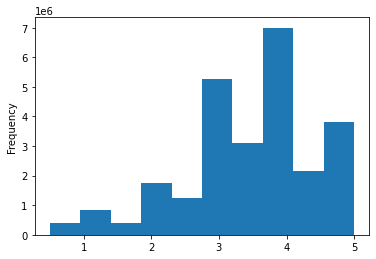

In [48]:
pd.options.display.float_format = '{:20,.2f}'.format
kaggle_ratings_df['rating'].plot(kind='hist')
kaggle_ratings_df['rating'].describe()

The statistical info along with the histogram show that the ratings data doesn't
any obvious errors or problems.

<hr/>